# SparkCognition Tabular Data Challenge

Nicholas Griffin

July 29, 2021

Our client, a local football team, is developing their offensive and defensive strategies for the coming season. They would like to use "AI" to help determine when "going for it" on 4th down makes sense, and to determine when their opponent is likely to attempt a 4th-down conversion so they can make the appropriate real-time substitutions. To keep their opponents off balance, they'd like to change the previous year's strategy for deciding these things, and they're assuming their opponents will do the same.

We have play-by-play data from last year's database (train.csv) and some test data (test.csv). The team's analytics staff has taken care of all the work that requires domain knowledge. They have evaluated each play/situation record and for each one that may be a candidate for a fourth-down conversion they have set the "is_candidate" value for the record to 'True'.

Design a model that can be used to predict whether a situation is a good 4th down conversion candidate or not. The model's inference time should be reliably short since it will be used in real time.

Provide the following:

1. The source code you used to build the model. You can use any language you like
2. A csv containing the predictions of the test data
3. A description of your model and an explanation why you chose this model over other models
4. An explanation of how you handled unbalanced data
5. An explanation of how you considered the inference time for the model


## Summary

1. Code to build the model is provided below in this notebook.

2. The .csv file entitled '' is included within the fork on this repository.

3. The model selected was a random forest classifier. Given the number of variables in this data set, this method was optimal to quickly determine the combination of features that would provide the best model fit with the potential to exclude features that are not informative to the classification. Gradient Boosting and XGBoost were also attempted and model fits compared, but Random Forest had the best combination of training accuracy, test accuracy, and F1 score, plus the quickest run time.

4. The dependent variable 'is_candidate' was unbalanced across the two options of the binary values; True had 5718 observations and False had 32,709 observations. To address this, I used random undersampling to reduce the number of the majority (False) class to the same number as the minority (True) class. Overall, addressing the imbalance is important to prevent the model from being biased toward predicting that the majority of test values should be in the majority class. This specific method was chosen because of the magnitude of the imbalance. Alternatives like oversampling and SMOTE could have been applied, but due to the potential need to increase the minority class by over 5x, the majority of the data in this class would have then been artificially generated. Undersampling instead allows for the model to train on true data and with sufficient volume for effective external validity.

5. Compared to the other models attempted, random forest had the quickest run time. The closest performing attempted model was XGBoost, but it took longer to run and had slightly worse classification predictions that random forest.

In [72]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import scipy
import statsmodels

data = pd.read_csv("~/Downloads/train_and_test_csvs/train.csv")
data

,Unnamed: 0,play_id,game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,is_candidate
0,32871,1702,182,27,20,1,13,21,0,28,...,1,-0.190419,0.355504,5.325706,3.0,1.000000,1.000000,0.903811,9.618890,False
1,4900,1326,27,16,22,1,2,23,0,17,...,0,-0.702470,0.647160,3.251048,2.0,0.987339,0.562080,0.631283,36.871707,False
2,9498,4109,52,9,14,1,4,15,0,10,...,1,-0.000000,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False
3,22854,1583,127,26,13,1,9,14,0,27,...,1,0.803693,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.778593,-77.859265,False
4,36810,265,204,16,27,1,14,28,0,17,...,0,-0.477283,1.292939,10.508274,10.0,0.386223,0.181228,0.427769,57.223058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38422,16410,4026,90,9,30,1,6,10,1,31,...,0,0.000000,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False
38423,9644,3400,53,10,15,1,4,16,0,11,...,1,1.585091,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.649206,35.079449,False
38424,6154,619,34,0,4,1,3,1,1,5,...,0,1.013741,2.854972,3.151539,4.0,0.636018,0.636018,0.357509,64.249101,True
38425,33991,2492,188,2,28,1,13,29,0,3,...,0,0.185703,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False


Check for any missing values.

In [73]:
data.isnull().values.any()

False

Examine the imbalance in the dependent variable.

In [74]:
import matplotlib.pyplot as plt
data.groupby(['is_candidate'])['play_id'].count()

is_candidate
False    32709
True      5718
Name: play_id, dtype: int64

Create a numerical binary version of the dependent variable.

In [75]:
data['is_candidate_num'] = (data['is_candidate'] == True).astype(int)
data

,Unnamed: 0,play_id,game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,is_candidate,is_candidate_num
0,32871,1702,182,27,20,1,13,21,0,28,...,-0.190419,0.355504,5.325706,3.0,1.000000,1.000000,0.903811,9.618890,False,0
1,4900,1326,27,16,22,1,2,23,0,17,...,-0.702470,0.647160,3.251048,2.0,0.987339,0.562080,0.631283,36.871707,False,0
2,9498,4109,52,9,14,1,4,15,0,10,...,-0.000000,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False,0
3,22854,1583,127,26,13,1,9,14,0,27,...,0.803693,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.778593,-77.859265,False,0
4,36810,265,204,16,27,1,14,28,0,17,...,-0.477283,1.292939,10.508274,10.0,0.386223,0.181228,0.427769,57.223058,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38422,16410,4026,90,9,30,1,6,10,1,31,...,0.000000,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False,0
38423,9644,3400,53,10,15,1,4,16,0,11,...,1.585091,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.649206,35.079449,False,0
38424,6154,619,34,0,4,1,3,1,1,5,...,1.013741,2.854972,3.151539,4.0,0.636018,0.636018,0.357509,64.249101,True,1
38425,33991,2492,188,2,28,1,13,29,0,3,...,0.185703,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False,0


Randomly undersample the majority class to match the size of the minority class.

In [76]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy = 'majority')
labels = np.array(data['is_candidate_num'])
feat_set = data.drop(['is_candidate','is_candidate_num'], axis=1)
feat_set_list = list(feat_set.columns)
x_sampled, y_sampled = undersample.fit_resample(data[feat_set_list], data['is_candidate_num'])

In [77]:
x_sampled

,Unnamed: 0,play_id,game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,2566,484,14,7,30,1,1,31,0,8,...,0,1,-0.655664,1.286789,10.021414,9.0,0.343862,0.292199,0.981005,1.899499
1,24278,1016,135,29,0,1,10,1,0,30,...,0,1,2.096390,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000
2,20301,3876,112,5,17,1,8,18,0,6,...,0,0,-1.018991,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.375989,62.401080
3,13804,1909,76,25,24,1,5,0,-1,0,...,0,0,0.000000,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000
4,3146,1197,17,23,3,1,2,4,0,24,...,0,1,-0.353745,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.249571,-24.957146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11431,38996,2223,216,8,16,1,15,9,1,17,...,0,0,0.724505,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.362503,-36.250314
11432,47500,3759,263,2,30,0,19,3,1,31,...,1,0,1.607691,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.974423,2.557701
11433,40616,2349,225,7,2,1,16,3,0,8,...,0,1,2.528997,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.973353,2.664691
11434,470,3188,2,24,3,1,1,25,1,4,...,0,0,1.224925,2.372721,10.628150,9.0,0.584948,0.584948,0.900147,9.985328


Read in the test data.

In [78]:
test = pd.read_csv("~/Downloads/train_and_test_csvs/test.csv")
test['is_candidate_num'] = (test['is_candidate'] == True).astype(int)
test

,Unnamed: 0,play_id,game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,is_candidate,is_candidate_num
0,3902,2265,21,30,13,1,2,31,1,14,...,0.067573,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False,0
1,29132,2710,161,7,26,1,11,8,1,27,...,-0.399119,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False,0
2,32242,3678,178,26,7,1,13,27,1,8,...,-0.076046,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.583510,-58.350998,False,0
3,29544,3879,163,22,4,1,12,23,1,5,...,-0.049834,0.524269,4.419764,3.0,0.695609,0.695609,0.524017,47.598338,False,0
4,22581,2956,125,17,11,1,9,12,0,18,...,-0.162814,0.423613,4.216651,2.0,0.614690,0.233894,0.774363,22.563684,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9602,34040,1,189,14,29,1,13,0,-1,0,...,-1.000000,0.000000,-1.000000,0.0,-1.000000,0.000000,-1.000000,0.000000,False,0
9603,6711,583,37,11,9,1,3,10,0,12,...,1.772523,0.602722,3.590369,2.0,0.987147,0.308109,0.523602,47.639805,False,0
9604,25475,3075,141,30,15,1,10,31,1,16,...,0.369636,-1.000000,0.000000,-1.0,0.000000,-1.000000,0.000000,0.000000,False,0
9605,41054,433,228,19,6,1,16,7,0,20,...,-0.415831,0.679561,4.335302,3.0,0.341160,0.080065,0.934879,6.512094,False,0


Check for missing values.

In [79]:
test.isnull().values.any()

False

Assess imbalance in dependent variable. Even with undersampling in the training set, it should still be able to effectively predict the DV in this test set.

In [80]:
test.groupby(['is_candidate_num'])['play_id'].count()

is_candidate_num
0    8188
1    1419
Name: play_id, dtype: int64

Model 1: Random Forest Classifier

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(x_sampled, y_sampled)
y_pred = rf.predict(test_feat)

In [101]:
y_pred = rf.predict(test_feat)
test['predictions'] = y_pred

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_label, y_pred))
print(classification_report(test_label,y_pred))
print(accuracy_score(test_label,y_pred))

[[6757 1431]
 [   2 1417]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      8188
           1       0.50      1.00      0.66      1419

    accuracy                           0.85      9607
   macro avg       0.75      0.91      0.78      9607
weighted avg       0.93      0.85      0.87      9607

0.850837930675549


Accuracy of just over 85% and F1 score for "True" outcomes of 66%. Only 2 false negative classifications.

Then, look at feature importance values (top ten):

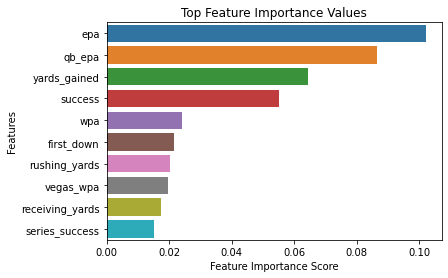


epa                0.102037
qb_epa             0.086574
yards_gained       0.064377
success            0.055166
wpa                0.024100
first_down         0.021404
rushing_yards      0.020209
vegas_wpa          0.019705
receiving_yards    0.017418
series_success     0.015234
dtype: float64


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

feature_imp = pd.Series(rf.feature_importances_, index = feat_set_list).sort_values(ascending = False)

sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top Feature Importance Values')
plt.show()
print()
print(feature_imp[0:10])

Model 2: Gradient Boosting Classifier

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

# Try multiple learning rates to optimize model fit.
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(x_sampled, y_sampled)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))


Learning rate:  0.05
Accuracy score (training): 0.854
Accuracy score (validation): 0.847
Learning rate:  0.075
Accuracy score (training): 0.854
Accuracy score (validation): 0.849
Learning rate:  0.1
Accuracy score (training): 0.860
Accuracy score (validation): 0.860
Learning rate:  0.25
Accuracy score (training): 0.878
Accuracy score (validation): 0.875
Learning rate:  0.5
Accuracy score (training): 0.873
Accuracy score (validation): 0.873
Learning rate:  0.75
Accuracy score (training): 0.895
Accuracy score (validation): 0.893
Learning rate:  1
Accuracy score (training): 0.875
Accuracy score (validation): 0.874


In [86]:
# Learning rate of 0.75 had the best fit.
gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(x_sampled, y_sampled)
predictions = gb_clf2.predict(test_feat)

print("Confusion Matrix:")
print(confusion_matrix(test_label, predictions))

print("Classification Report")
print(classification_report(test_label, predictions))

Confusion Matrix:
[[6698 1490]
 [  62 1357]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      8188
           1       0.48      0.96      0.64      1419

    accuracy                           0.84      9607
   macro avg       0.73      0.89      0.77      9607
weighted avg       0.91      0.84      0.86      9607



Overall, not as effective at predicting the DV as random forest. Lower accuracy and precision/recall/F1, as evidenced by the higher counts of false negatives and false positives.

Model 3: XGBoost Classifier

In [87]:
from xgboost import XGBClassifier

In [88]:
# Try multiple learning rates to optimize model fit.
for learning_rate in lr_list:
    gb_clf = XGBClassifier(learning_rate=learning_rate)
    gb_clf.fit(x_sampled, y_sampled)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.913
Accuracy score (validation): 0.911
Learning rate:  0.075
Accuracy score (training): 0.913
Accuracy score (validation): 0.911
Learning rate:  0.1
Accuracy score (training): 0.913
Accuracy score (validation): 0.911
Learning rate:  0.25
Accuracy score (training): 0.914
Accuracy score (validation): 0.912
Learning rate:  0.5
Accuracy score (training): 0.920
Accuracy score (validation): 0.920
Learning rate:  0.75
Accuracy score (training): 0.924
Accuracy score (validation): 0.924
Learning rate:  1
Accuracy score (training): 0.927
Accuracy score (validation): 0.926


In [89]:
# Learning rate of 1 was the best fit.
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(learning_rate = 1)
xgb_clf.fit(x_sampled, y_sampled)
score = xgb_clf.score(test_feat, test_label)
print(score)

0.8485479337982721


In [90]:
predictions = xgb_clf.predict(test_feat)

print("Confusion Matrix:")
print(confusion_matrix(test_label, predictions))

print("Classification Report")
print(classification_report(test_label, predictions))

Confusion Matrix:
[[6879 1309]
 [ 146 1273]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      8188
           1       0.49      0.90      0.64      1419

    accuracy                           0.85      9607
   macro avg       0.74      0.87      0.77      9607
weighted avg       0.91      0.85      0.86      9607



Better performance than Gradient Boosting, but still not as good as random forest by metrics or computation time. Feature importance metrics below are also less intuitive than those from random forest.

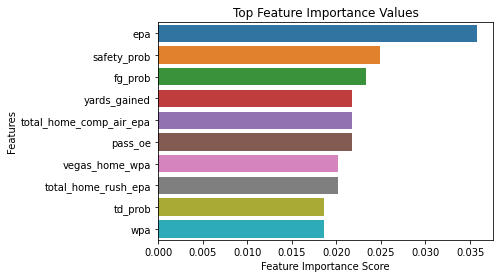


epa                        0.035770
safety_prob                0.024883
fg_prob                    0.023328
yards_gained               0.021773
total_home_comp_air_epa    0.021773
pass_oe                    0.021773
vegas_home_wpa             0.020218
total_home_rush_epa        0.020218
td_prob                    0.018663
wpa                        0.018663
dtype: float32


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

feature_imp2 = pd.Series(xgb_clf.feature_importances_, index = feat_set_list).sort_values(ascending = False)

sns.barplot(x=feature_imp2[0:10], y=feature_imp2.index[0:10])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top Feature Importance Values')
plt.show()
print()
print(feature_imp2[0:10])

In [105]:
# Printing out the predictions from the best model - random forest classifier
y_pred = rf.predict(test_feat)
test['predictions'] = y_pred
test.to_csv("test_with_predictions.csv")